<a href="https://colab.research.google.com/github/vkarakcheev/DS/blob/main/Pet-projects/logit_vs_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOGIT vs FOREST

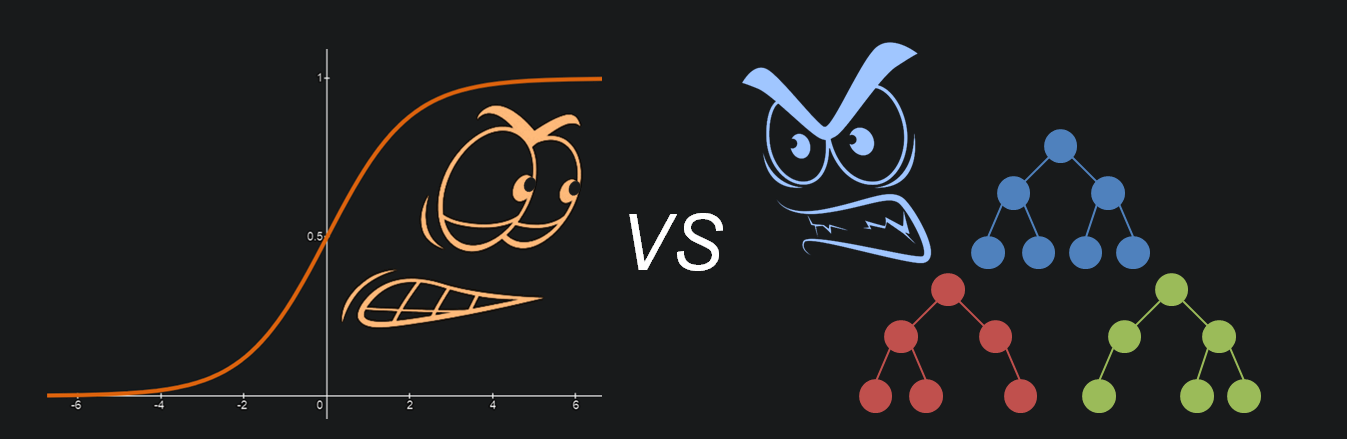

Цель исследования – подтвердить или опровергнуть следующее утверждение-гипотезу [отсюда](https://youtu.be/Us_TKT8ZL2E?t=5299).
>*В задаче бинарной классификации **любые** метрики качества модели логистической регрессии будут **гораздо** лучше метрик модели случайного леса, если **подавляющее большинство** признаков в данных являются незначащими (шумом).*

Для этого качество моделей логистической регресии и случайного леса будем сравнивать на ситнетических датасетах трех уровней «сложности» по четыре модификации с разной долей значащих признаков в каждом.

<font color='orange'>Внимание:</font> время выполнения всей тетрадки в Google Colab составляет <u>более двух часов</u>.

# PREPARE to <font color='red'>FIGHT</font>

Подключим необходимые модули и выставим полезные умолчания.

In [ ]:
!pip install scikit-optimize catboost

     |████████████████████████████████| 100 kB 3.3 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import pickle

from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             RocCurveDisplay, PrecisionRecallDisplay)
from time import perf_counter
from datetime import timedelta

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_columns', None);  # Display all dataframe columns

# Disable warnings
pd.options.mode.chained_assignment = None;   
warnings.simplefilter('ignore', pd.errors.PerformanceWarning);
warnings.simplefilter('ignore', UserWarning);

Определим ключевые константы.

In [ ]:
# General constants
RS = 22221117                         # Random state
N_ITER = 100                          # Iterations for Bayesian search
CV = 5                                # Cross validation folds
N_JOBS = multiprocessing.cpu_count()  # Number of CPU
# Folder for pickle and unpickle results
FOLDER = '/content/drive/MyDrive/Colab Notebooks/logit_forest/'


# Logit constants
C_SPACE = np.logspace(-3, 3, 13)
LOGIT_SPACE = [
    {'solver': ['newton-cg', 'lbfgs', 'liblinear'],  #, 'sag'],
     'penalty': ['l2'], 
     'C': C_SPACE
    },
    {'solver': ['newton-cg', 'lbfgs'],  #, 'sag'],
     'penalty': ['none']
    },
    {'solver': ['liblinear'],
     'penalty': ['l1'], 
     'C': C_SPACE[:-3]
    },
    # Large C-values can hang liblinear solver with l1 penalty on some datasets
    {'solver': ['liblinear'],
     'penalty': ['l1'], 
     'C': C_SPACE[-3:]
    },
    # SAG and SAGA solvers are not used as they are very slow 
    #  and give poorer quality
]

# Random forest constants
N_ESTIMATORS_SPACE = Integer(1, 100, transform='identity')
MAX_DEPTH_SPACE = Integer(1, 30, transform='identity')
FOREST_SPACE = {
    'n_estimators': N_ESTIMATORS_SPACE,
    'max_depth': MAX_DEPTH_SPACE,
}

Датасеты для анализа будем генерировать функцией [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) библиотеки `scikit-learn`, которая делает следующее.
1. Генерирует 2<sup>`n_informative`</sup> кластеров точек (наборов признаков), нормально распределенных вокруг вершин `n_informative`-мерного гиперкуба с длиной ребра 2 × `class_sep`.
2. Относит по `n_clusters_per_class` кластеров к каждому из `n_classes` классов.
3. Оставшиеся кластеры (если есть) игнорирует.
4. Добавляет:
    - `n_redundant` избыточных признаков, являющихся случайной линейной комбинацией `n_informative` значащих признаков,
    - `n_repeated` признаков-дубликатов значащих и избыточных признаков (с возвращениями)
    - и (`n_features` − `n_informative` − `n_redundant` − `n_repeated`) незначащих признаков (случайный шум).

Если передать функции аргумент `shuffle=False`, то `n_features` столбцов признаков будут следовать в следующем порядке:
- `n_informative` значащих,
- `n_redundant` избыточных,
-  `n_repeated` дубликатов
- и (`n_features` − `n_informative` − `n_redundant` − `n_repeated`) незначащих признаков.

Для простоты, скорости и наглядности будем генерировать датасеты с *тремя* значащими признаками (чтобы визуализировать их в 3D-диаграммах) и разным количеством незначащих, меняя таким образом долю последних.

Функцией `plot_blobs` будем генерировать и визуализировать датасет с заданными параметрами. В ней ребро куба намеренно сделаем увеличенным (`class_sep=5`), чтобы лучше видеть относительное расположение кластеров.

In [ ]:
def plot_blobs(n_samples=1000, n_features=3, n_informative=3, 
                n_clusters_per_class=3, class_sep=5, n_redundant=0, 
                n_repeated=0, random_state=RS, title=None):
    '''Generates dataset and plots it in 3D'''
    
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        random_state=random_state,
        shuffle=False,  # All informative features are in first columns
    )

    X, y = pd.DataFrame(X), pd.Series(y)
    c0, c1 = y == 0, y == 1

    fig = plt.figure(figsize=(10, 8));
    fig.suptitle(title, y=.9, fontsize='xx-large');
    ax = fig.add_subplot(projection='3d');

    ax.scatter(X[c0][0], X[c0][1], X[c0][2], label='Class 0', c='b', 
               edgecolors='k');
    ax.scatter(X[c1][0], X[c1][1], X[c1][2], label='Class 1', c='r', 
               edgecolors='k');

    ax.set(xlabel='Feature 1', ylabel='Feature 2', zlabel='Feature 3')
    ax.legend();

Функция `plot_curves` для обученной модели и выборки будет рисовать кривые ROC и Precision-Recall, заодно считая площади под ними: AUC и AP.

In [ ]:
def plot_curves(estimator, X, y, title=''):
    '''Plots ROC and Precision-Recall curves
    for a given estimator, X and y.
    '''
    
    if hasattr(estimator, 'best_estimator_'):
        estimator = estimator.best_estimator_
    
    # Prepare axes
    fig, ax = plt.subplots(1, 2, figsize=(10, 3));
    fig.suptitle(title + estimator.__class__.__name__);
    ax[0].set(xlim=(-.05, 1.05), ylim=(-.05, 1.05));
    ax[1].set(xlim=(-.05, 1.05), ylim=(-.05, 1.05));
    ax[0].plot([0, 1], [0, 1], linestyle='--', color=(.3, .3, .3));
    ax[1].plot([0, 1], [.5, .5], linestyle='--', color=(.3, .3, .3));

    # Plot curves
    RocCurveDisplay.from_estimator(estimator, X, y, ax=ax[0], name='');
    PrecisionRecallDisplay.from_estimator(estimator, X, y, ax=ax[1], name='');

    # Mark the point of threshold = 0.5
    tn, fp, fn, tp = confusion_matrix(y, estimator.predict(X)).ravel()
    ax[0].plot(fp/(tn+fp), tp/(tp+fn), 'ro');
    ax[1].plot(tp/(tp+fn), tp/(tp+fp), 'ro');
    
    plt.show();

Основная функция `fight`:
- генерирует датасет по заданным параметрам,
- разбивает его на обучающую и тестовую выборки,
- подбирает гиперпараметры моделей логистической регрессии и случайного леса на обучающей выборке,
- рисует кривые ROC и Precision-Recall моделей на тестовой выборке,
- определяет модель-победителя по метрике AUC ROC на тестовой выборке.

Функция также опционально (если аргумент `skip_cat=False`) обучает и тестирует модель градиентного бустинга CatBoost для использования в качестве бенчмарка.

In [ ]:
def fight(n_samples=1000, n_features=3, n_informative=3, 
          n_clusters_per_class=3, class_sep=1, n_redundant=0, n_repeated=0,
          random_state=RS, skip_logit=False, skip_forest=False, skip_cat=False, 
          liblinear_safe=False, title=''):
    '''Generates dataset, searches hyperparameters for Logistic Regression 
    and Random Forest models and compares their metrics. Optionally adds 
    CatBoost model results as a benchmark.
    '''
    T = perf_counter()
    
    # Global variables for skipping hyperparameters search for some models
    #  as well as analyzing search history (see Misc section)
    global logit, forest, cat, logit_score, forest_score, cat_score

    # Generate and split dataset
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        random_state=random_state
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.25, stratify=y, random_state=random_state)
   
    # Logit hyperparameters search
    t = perf_counter()
    if not skip_logit:
        logit = GridSearchCV(
            LogisticRegression(max_iter=10000, random_state=random_state), 
            LOGIT_SPACE if not liblinear_safe else LOGIT_SPACE[:-1], 
            scoring='roc_auc', 
            cv=CV,
            n_jobs=N_JOBS
        ).fit(X_train, y_train);
    if 'logit' in globals():
        plot_curves(logit, X_test, y_test, title=title)
        logit_score = roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])
    else: logit_score = None
    print('Logit time:', 
          str(timedelta(seconds=perf_counter()-t)).split('.')[0], '\n')

    # Forest hyperparameters search
    t = perf_counter()
    if not skip_forest:
        forest = BayesSearchCV(
            RandomForestClassifier(random_state=random_state), 
            FOREST_SPACE, 
            n_iter=N_ITER,
            scoring='roc_auc', 
            cv=CV, 
            random_state=random_state,
            n_jobs=N_JOBS
        ).fit(X_train, y_train)
    if 'forest' in globals():
        plot_curves(forest, X_test, y_test, title=title)
        forest_score = roc_auc_score(y_test, 
                                     forest.predict_proba(X_test)[:, 1])
    else: forest_score = None
    print('Forest time:', 
          str(timedelta(seconds=perf_counter()-t)).split('.')[0], '\n')

    # Benchmark
    t = perf_counter()
    if not skip_cat:
        cat = CatBoostClassifier(
            eval_metric='AUC', 
            silent=True,
            random_state=random_state
        ).fit(X_train, y_train)
    if 'cat' in globals():
        plot_curves(cat, X_test, y_test, title=title)
        cat_score = roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])
    else: cat_score = None
    print('Cat time:', 
            str(timedelta(seconds=perf_counter()-t)).split('.')[0], '\n')

    print('TOTAL time:', 
          str(timedelta(seconds=perf_counter()-T)).split('.')[0])
    
    if logit_score and forest_score:
        if logit_score > forest_score: 
            print('LOGIT WINS')
        else: 
            print('FOREST WINS')
    
    return logit_score, forest_score, cat_score

В датафреймы `easy`, `medium` и `hard` будем записывать результаты замера качества моделей – метрику AUC ROC – при разной доле значащих признаков в датасете соответствующей «сложности». 

In [ ]:
easy = pd.DataFrame(
    index=pd.Index([1, .1, .01, .001], 
                   name='Share of Informative Features'),
    columns=pd.Series(['Logit', 'Forest', 'CatBoost'], 
                      name='Classifier')
)
medium = easy.copy()
hard = easy.copy()

Функцией `plot_lines` будем визуализировать датафреймы с результатами.

In [ ]:
def plot_lines(frames, frame_titles=None, title=None):
    '''Plots AUC vs share of informative features stored in dataframes
    frames (one classification difficulty level per dataframe)'''
    if not isinstance(frames, list):
        frames = [frames]
    n = len(frames)
    if not frame_titles:
        frame_titles = [None] * n
    fig, ax = plt.subplots(1, n, figsize=(6*n, 4))
    fig.suptitle(title, y=1.05, size='x-large')
    if n == 1:
        ax = [ax]
    for (df, ax, ft) in zip(frames, ax, frame_titles):
        df.plot(title=ft, ax=ax, ylim=(.5, 1))
        ax.set_xscale('log')
        ax.invert_xaxis()
        ax.set_ylabel('AUC')

# Difficulty – <font color='ligreen'>EASY</font>

Начнем битву моделей с «легкого» варианта датасета. Если в функции `make_classification` использовать все кластеры (в нашем случае 2<sup>3</sup> = 8), т.е. установить `n_clusters_per_class=4` (по 4 кластера на каждый из двух классов), она поделит их между классами почему-то не случайным образом, а вдоль одного из ребер куба (в примере на диаграмме ниже – вертикального). В этом случае классы легко разделяются плоскостью, перпендикулярной этому ребру (на диаграмме – горизонтальной), и по сути значимым остается *лишь один* признак, ось которого перпендикулярна этой плоскости (на диаграмме – `Feature 3`).

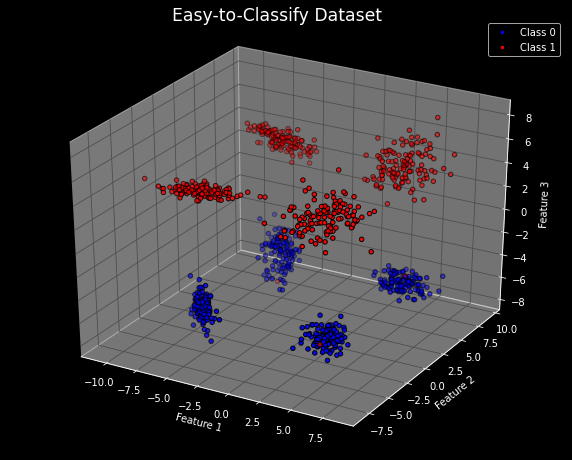

In [ ]:
plot_blobs(n_clusters_per_class=4, title='Easy-to-Classify Dataset')

Напомним, что для визуализации длина ребра куба намеренно увеличена: `class_sep=5`. В датасетах, используемых далее для сравнения моделей, она будет впятеро короче: `class_sep=1` (размер кластеров при этом не меняется), поэтому кластеры будут сильно заезжать друг на друга. Это добавит датасетам сложности и естественности и не позволит моделям даже в самом легком варианте идеально разделить классы.

Посмотрим, как справятся модели с этим датасетом. Сравним качество моделей на четырех его модификациях: с 3, 30, 300 и 3000 признаками, из которых значащими всегда будут только 3, т.е. доля значащих признаков будет 100, 10,  1 и 0,1%.

## <font color='orange'><i>ROUND 1</i></font>

<font color='red'><b>FIGHT!</b></font>

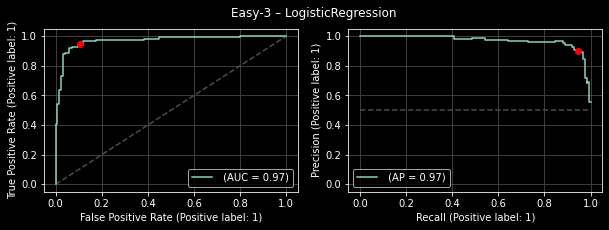

Logit time: 0:00:02 



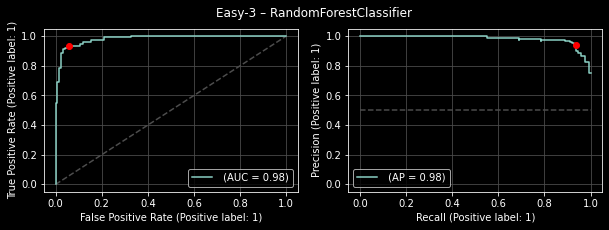

Forest time: 0:05:23 



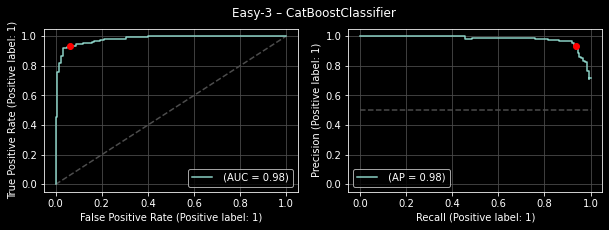

Cat time: 0:00:01 

TOTAL time: 0:05:27
FOREST WINS


In [ ]:
easy.loc[1] = fight(n_clusters_per_class=4, n_features=3,
    title='Easy-3 – ')

Датасет без незначащих признаков не вызвал затруднений ни у одной из моделей: обе метрики предельно высоки у всех. Формально лес чуть впереди логита.

## <font color='orange'><i>ROUND 0.1</i></font>

<font color='red'><b>FIGHT!</b></font>

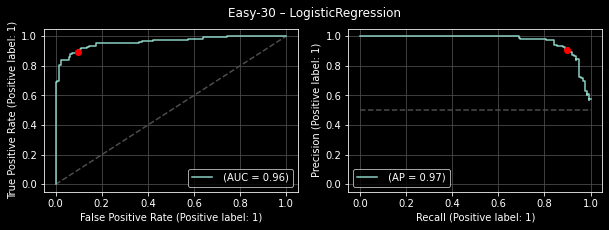

Logit time: 0:00:05 



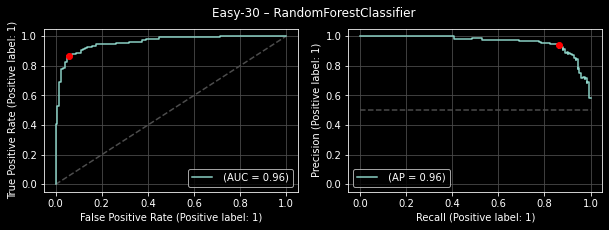

Forest time: 0:05:51 



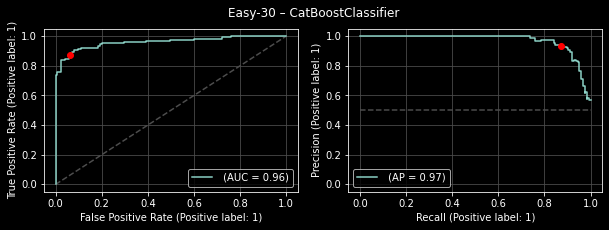

Cat time: 0:00:08 

TOTAL time: 0:06:05
LOGIT WINS


In [ ]:
easy.loc[.1] = fight(n_clusters_per_class=4, n_features=30,
    title='Easy-30 – ')

Снижения доли значащих признаков до 10% модели почти не заметили: метрики незначительно снизились у всех. Логит технически впереди. 

## <font color='orange'><i>ROUND 0.01</i></font>

<font color='red'><b>FIGHT!</b></font>

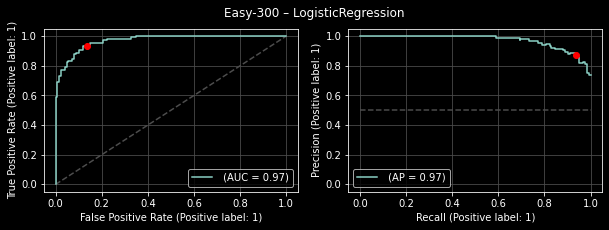

Logit time: 0:00:12 



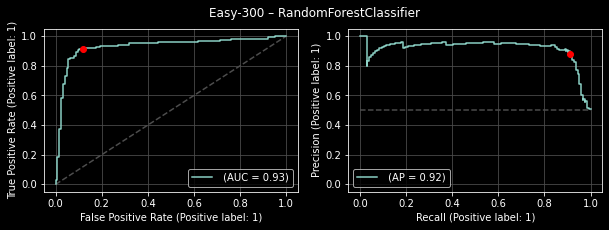

Forest time: 0:06:41 



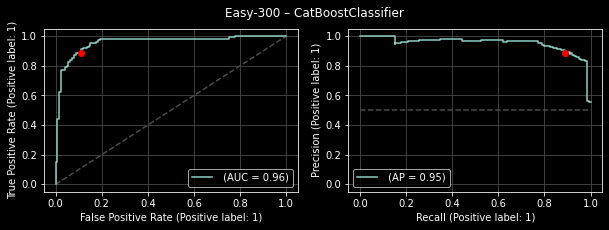

Cat time: 0:01:20 

TOTAL time: 0:08:14
LOGIT WINS


In [ ]:
easy.loc[.01] = fight(n_clusters_per_class=4, n_features=300,
    title='Easy-300 – ')

При 1% значащих признаков лес немного поплыл, особенно в кривой Precision-Recall. Слегка дрогнул даже CatBoost. А вот логит будто даже и не почувствовал изменений и остался лидером.

## <font color='orange'><i>ROUND 0.001</i></font>

<font color='red'><b>FIGHT!</b></font>

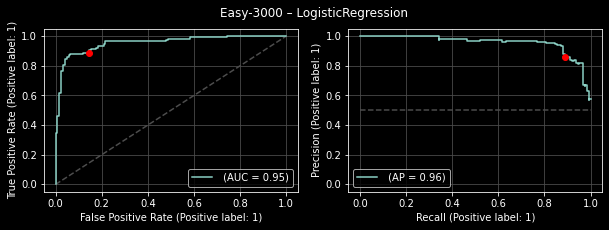

Logit time: 0:00:39 



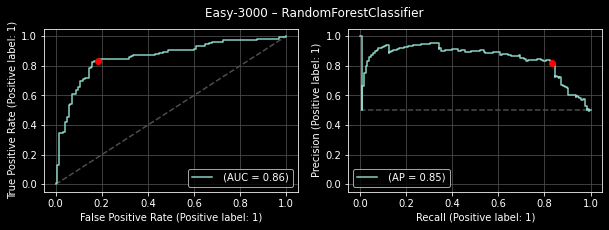

Forest time: 0:07:12 



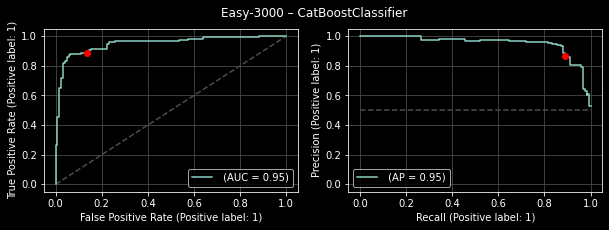

Cat time: 0:14:31 

TOTAL time: 0:22:24
LOGIT WINS


In [ ]:
easy.loc[.001] = fight(n_clusters_per_class=4, n_features=3000,
    title='Easy-3000 – ')

При доле значащих признаков в 0,1% качество логита снизилось незначительно, а вот у леса значительно. CatBoost выдержал и сохранил качество на прежнем уровне.

## <font color='red'><i>FINISH HIM!</i></font>

In [ ]:
# Saving results to file if needed
# with open(FOLDER + 'easy.pickle', 'wb') as f: pickle.dump(easy, f)

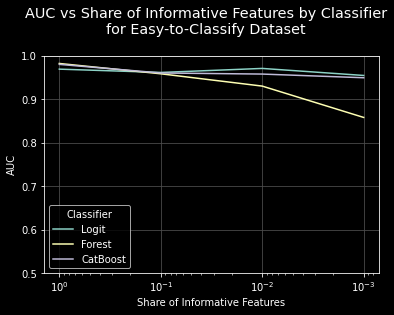

In [ ]:
plot_lines(easy, title="AUC vs Share of Informative Features by Classifier\n"
    + "for Easy-to-Classify Dataset")

В итоге на «легком» датасете у модели логистической регрессии наблюдается высокая резистентность качества к увеличению доли незначащих признаков во всем диапазоне их доли. В отличие от нее качество модели случайного леса демонстрирует чувствительность к *очень низким* долям значащих признаков. *Значительное* преимущество логистической регрессии над случайным лесом наблюдается лишь при экстремальныо низкой доле значащих признаков порядка 0,1%.

# Difficulty – <font color='orange'>MEDIUM</font>

Теперь сконструируем датасет средней «сложности». К каждому классу отнесем не максимальные 4, а лишь 2 кластера. Когда число кластеров на класс меньше максимального, `make_classification` распределяет их по классам несимметрично. В результате (см. диаграмму ниже) в нашем случае мы получаем пары кластеров, которые хоть и можно по-прежнему разделить плоскотью, но только составляющей ненулевой угол со всеми тремя осями признаков. Это значит, что для классификации важны будут *все три* признака. 

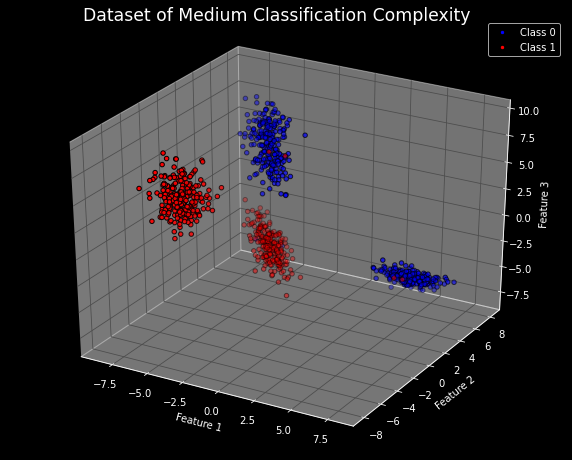

In [ ]:
plot_blobs(n_clusters_per_class=2,
           title='Dataset of Medium Classification Complexity')

Снова напомним, что в «боевых» датасетах расстояние между кластерами будет гораздо меньше.

Повторим сравнение моделей на четырех модификациях уже «среднего» датасета: со 100, 10, 1 и 0,1% значащих признаков.

## <font color='orange'><i>ROUND 1</i></font>

<font color='red'><b>FIGHT!</b></font>

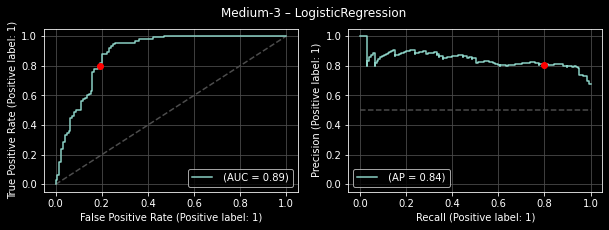

Logit time: 0:00:04 



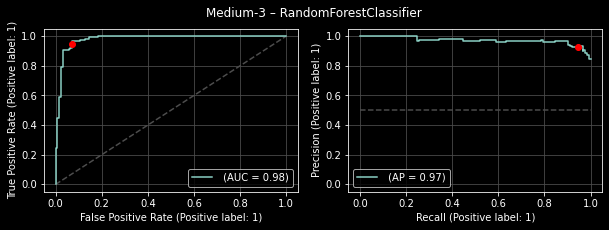

Forest time: 0:05:10 



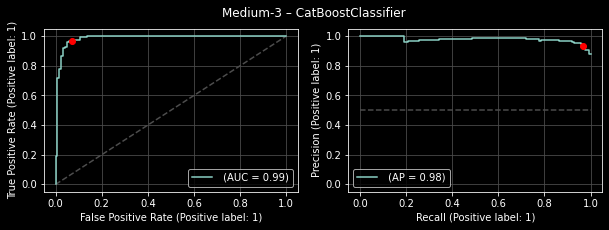

Cat time: 0:00:01 

TOTAL time: 0:05:16
FOREST WINS


In [ ]:
medium.loc[1] = fight(n_clusters_per_class=2, n_features=3,
    title='Medium-3 – ')

Логит заметно потерял в качестве уже на старте – при отсутствии незначащих признаков. А вот лес даже не заметил усложнения датасета: его метрики предельно высокие.

## <font color='orange'><i>ROUND 0.1</i></font>

<font color='red'><b>FIGHT!</b></font>

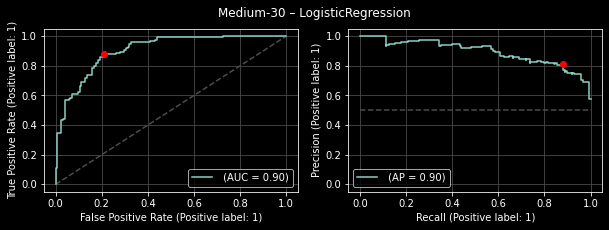

Logit time: 0:00:04 



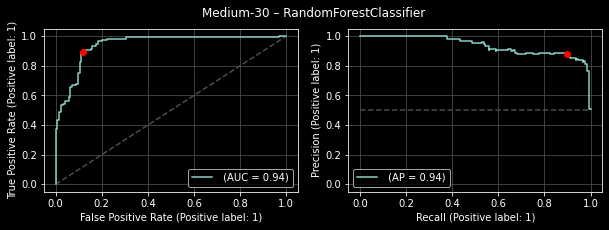

Forest time: 0:05:48 



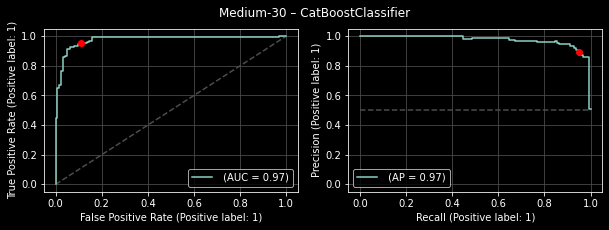

Cat time: 0:00:08 

TOTAL time: 0:06:01
FOREST WINS


In [ ]:
medium.loc[.1] = fight(n_clusters_per_class=2, n_features=30,
    title='Medium-30 – ')

Снижение доли значащих признаков до 10% не сказалось на качестве логита, а лес начал немного проседать, оставаясь впереди. CatBoost пока держится.

## <font color='orange'><i>ROUND 0.01</i></font>

<font color='red'><b>FIGHT!</b></font>

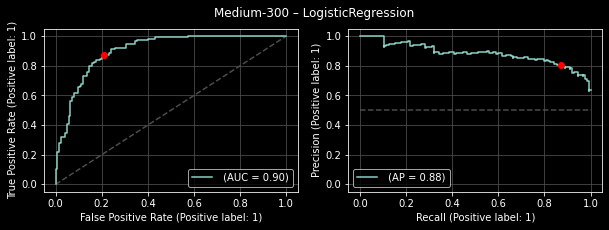

Logit time: 0:00:14 



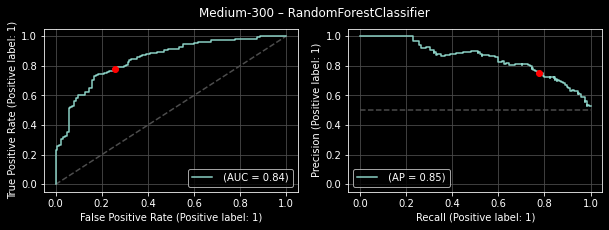

Forest time: 0:06:42 



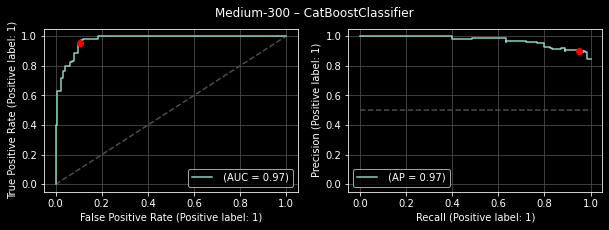

Cat time: 0:01:20 

TOTAL time: 0:08:18
LOGIT WINS


In [ ]:
medium.loc[.01] = fight(n_clusters_per_class=2, n_features=300,
    title='Medium-300 – ')

Вместе с падением доли значащих признаков до 1% качество леса упало ниже неизменившегося логита. Кэтбусту удалось удержать качество практически на исходном уровне.

## <font color='orange'><i>ROUND 0.001</i></font>

<font color='red'><b>FIGHT!</b></font>

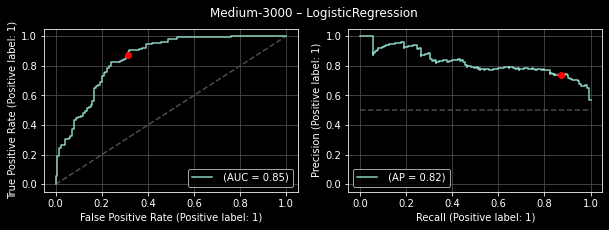

Logit time: 0:00:43 



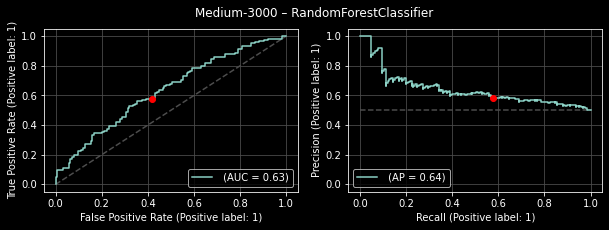

Forest time: 0:11:13 



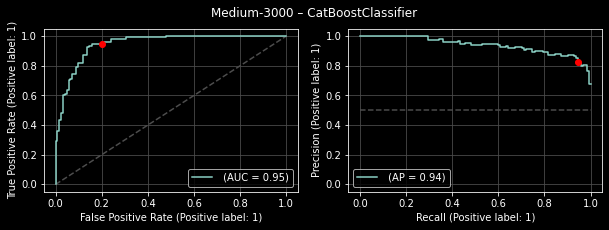

Cat time: 0:13:10 

TOTAL time: 0:25:07
LOGIT WINS


In [ ]:
medium.loc[.001] = fight(n_clusters_per_class=2, n_features=3000,
    title='Medium-3000 – ')

При дальнейшем падении доли значащих признаков до 0,1% качество логита немного снизилось, а вот у леса оно просто обвалилось. CatBoost незначительно ухудшился но сохранил высокое качество.

## <font color='red'><i>FINISH HIM!</i></font>

In [ ]:
# Saving results to file if needed
# with open(FOLDER + 'medium.pickle', 'wb') as f: pickle.dump(medium, f)

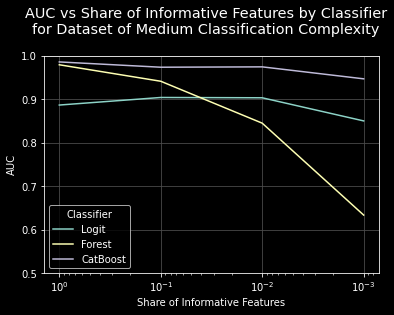

In [ ]:
plot_lines(medium, title="AUC vs Share of Informative Features by Classifier\n"
    + "for Dataset of Medium Classification Complexity")

В итоге на датасете средней «сложности» мы видим заметные затруднения модели логистической регрессии по сравнению с «легким» датасетом, но снова с почти нулевой чувствительностью к росту числа незначащих фич. Реакция же модели случайного леса на этот рост здесь проявилась гораздо сильнее: настолько, что лес начал заметно уступать регрессии уже при 1% значащих признаков. Снова *значительное* преимущество логистической регрессии проявляется лишь при очень низкой доле значащих признаков: 1% и ниже.

# Difficulty – <font color='red'>HARD</font>

Наконец, самый «сложный» датасет. При трех кластерах на класс можно добиться такой конфигурации кластеров (дефолтный `random state` выбран не случайно), что классы невозможно разделить просто плоскостью, для этого понадобится более сложная поверхность.

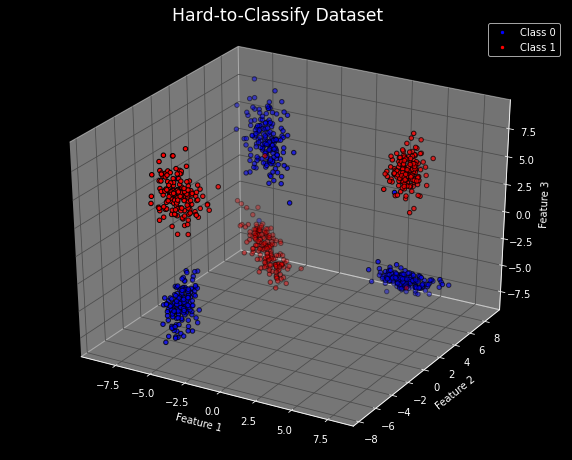

In [ ]:
plot_blobs(n_clusters_per_class=3,
           title='Hard-to-Classify Dataset')

А в «боевом» варианте датасета дополнительным усложнением, как всегда, будет еще и пересечение кластеров из-за близости.

Как и раньше, сравним модели на четырех модификациях «сложного» датасета: со 100, 10, 1 и 0,1% значащих признаков. Пожелаем моделям удачи.

## <font color='orange'><i>ROUND 1</i></font>

<font color='red'><b>FIGHT!</b></font>

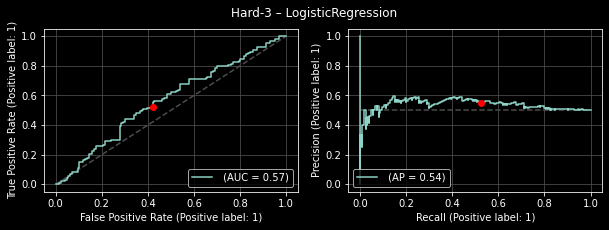

Logit time: 0:00:04 



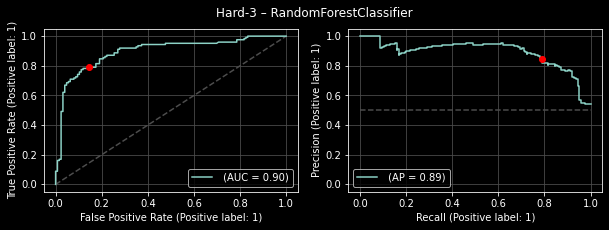

Forest time: 0:05:38 



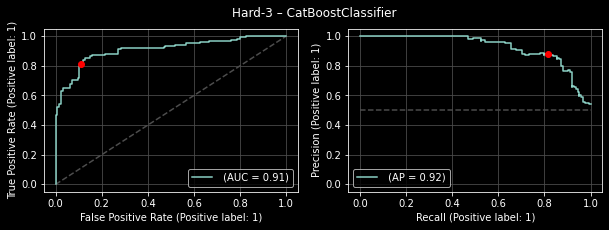

Cat time: 0:00:02 

TOTAL time: 0:05:44
FOREST WINS


In [ ]:
hard.loc[1] = fight(n_clusters_per_class=3, n_features=3,
    title='Hard-3 – ')

«Сложный» датасет оказался не по зубам логиту: его метрики качества несильно превышают метрики случайных предсказаний. Лес на данных без незначащих признаков показывает хороший результат. CatBoost немногим лучше леса.

## <font color='orange'><i>ROUND 0.1</i></font>

<font color='red'><b>FIGHT!</b></font>

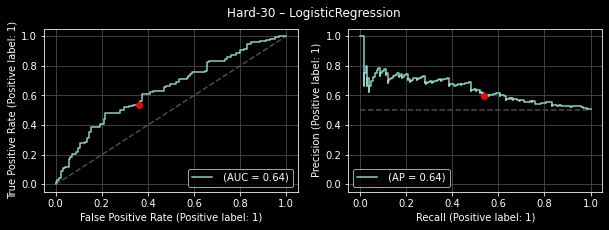

Logit time: 0:00:04 



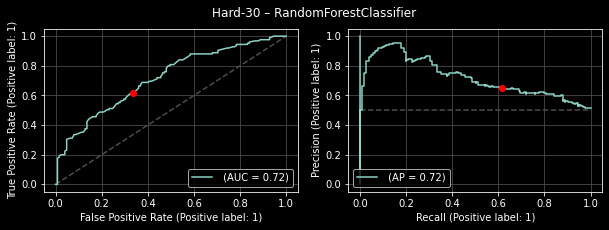

Forest time: 0:05:53 



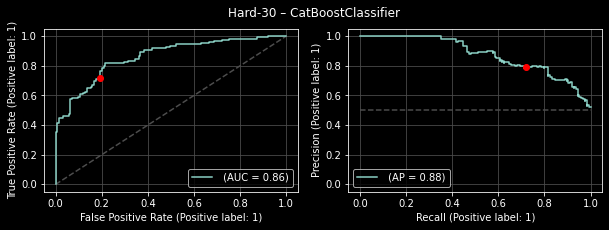

Cat time: 0:00:08 

TOTAL time: 0:06:06
FOREST WINS


In [ ]:
hard.loc[.1] = fight(n_clusters_per_class=3, n_features=30,
    title='Hard-30 – ')

При снижении доли значащих признаков до 10% качество логита даже несколько подросло. Лес очень сильно просел, но остался лидером. Немного ухудшились метрики даже у кэтбуста.

## <font color='orange'><i>ROUND 0.01</i></font>

<font color='red'><b>FIGHT!</b></font>

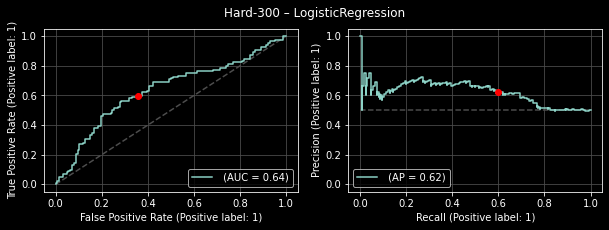

Logit time: 0:01:42 



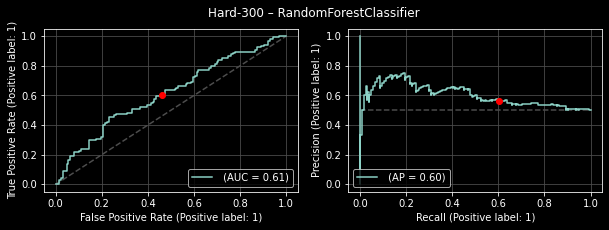

Forest time: 0:06:44 



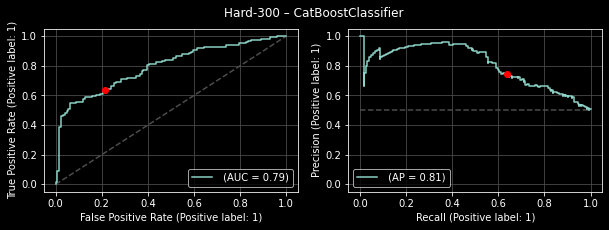

Cat time: 0:01:22 

TOTAL time: 0:09:48
LOGIT WINS


In [ ]:
hard.loc[.01] = fight(n_clusters_per_class=3, n_features=300, 
    liblinear_safe=True, title='Hard-300 – ')

При доле значащих признаков в 1% качество леса окончательно проваливается, уступая неизменившемуся логиту. Даже CatBoost проседает сильнее прежнего, но все же сохраняет метрики на неплохом уровне.

На этой модификации датасета модель логистической регрессии с сольвером `liblinear` и регуляризацией `l1` при обучении зависает, если значение параметра обратной силы регуляризации `C` больше или равно 10<sup>2</sup>. Поэтому для обучения здесь используется урезанный диапазон значений `C`.

## <font color='orange'><i>ROUND 0.001</i></font>

<font color='red'><b>FIGHT!</b></font>

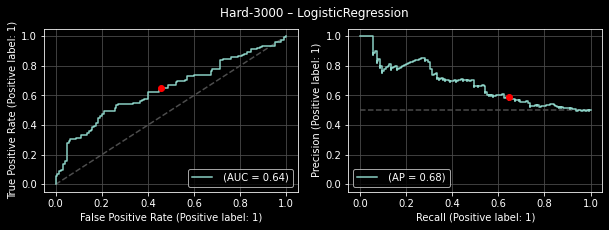

Logit time: 0:00:55 



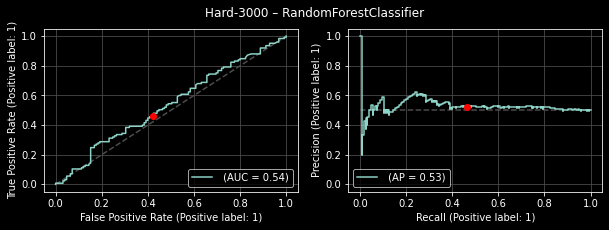

Forest time: 0:07:36 



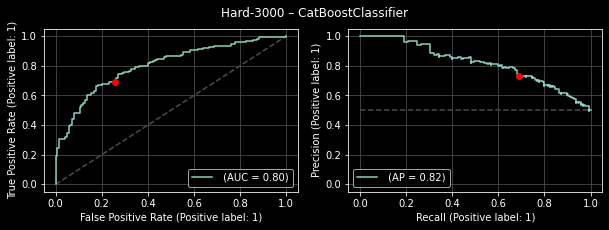

Cat time: 0:13:14 

TOTAL time: 0:21:46
LOGIT WINS


In [ ]:
hard.loc[.001] = fight(n_clusters_per_class=3, n_features=3000,
    title='Hard-3000 – ')

На датасете с экстремально низкой долей значащих признаков в 0,1% лес окончательно себя дискредитирует качеством, едва превышающим качество случайных предсказаний. Логиту же удается сохранить невысокое, но не бесполезное качество. CatBoost стоически удерживает качество на неплохом уровне.

## <font color='red'><i>FINISH HIM!</i></font>

In [ ]:
# Saving results to file if needed
# with open(FOLDER + 'hard.pickle', 'wb') as f: pickle.dump(hard, f)

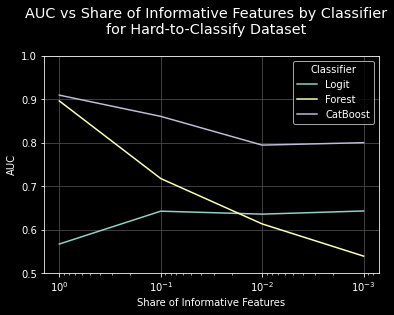

In [ ]:
plot_lines(hard, title="AUC vs Share of Informative Features by Classifier\n"
    + "for Hard-to-Classify Dataset")

«Сложный» датасет заставил попотеть даже модель CatBoost. Модель логистической регрессии показала невысокое, но стабильное качество,  практически нечувствительное к доле значащих признаков.

Модель случайного леса продемонстрировала на «сложном» датасете очень высокую чувствительность к доле значащих признаков: ее качество упало с хорошего при доле 100% до крайне плохого при доле 0,1%. *Значительный* ее проигрыш регрессии наблюдался при очень низкой доле: порядка 0,1%.



# <font color='red'><b>FATALITY</b></font>

In [ ]:
# Uploading previously saved results from files if needed
# with open(FOLDER + 'easy.pickle', 'rb') as f: easy = pickle.load(f)
# with open(FOLDER + 'medium.pickle', 'rb') as f: medium = pickle.load(f)
# with open(FOLDER + 'hard.pickle', 'rb') as f: hard = pickle.load(f)

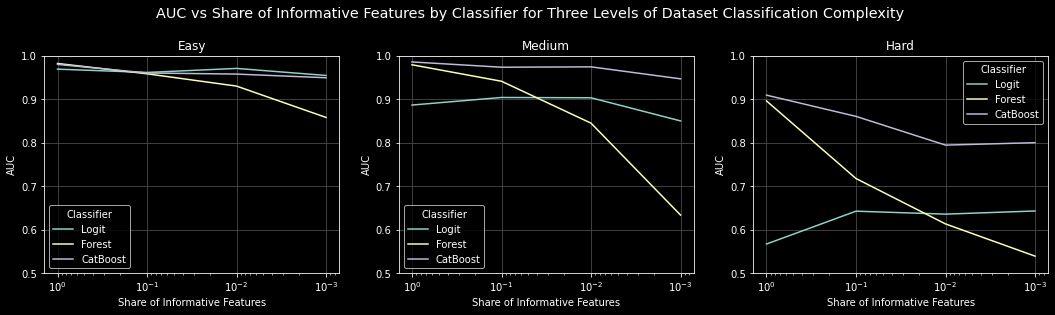

In [ ]:
plot_lines([easy, medium, hard], ['Easy', 'Medium', 'Hard'], 
           "AUC vs Share of Informative Features by Classifier "
           + "for Three Levels of Dataset Classification Complexity")

Учитывая такие ограничения данного исследования, как синтетические датасеты особой природы и неисчерпывающий поиск оптимальных гиперпараметров модели случайного леса, можно сделать следующие выводы.
- Исходная гипотеза в целом подтвердилась: при *подавляющем* большинстве незначащих признаков в данных модель логистической регрессии в задаче классификации *может* показывать *значительно* более высокие метрики качества, чем модель случайного леса.
- Превосходтсво модели логистической регресии над моделью случайного леса наблюдается при *очень низкой* (1% и ниже) доле значащих признаков. 
- Качество модели логистической регрессии *нечувствительно* к доле значащих признаков.
- Качество модели случайного леса в задаче классификации *может* *сильно* падать при снижении доли значащих признаков.
- Качество модели градиентного бустинга CatBoost в задаче классификации *может* *заметно* снижаться при *сильном* снижении доли значащих признаков.

Не исключено, что такие выводы могут быть специфичны для использованных в исследовании датасетов, сгенерированных с помощью функции `make_classification` библиотеки `scikit-learn`. Для  обобщения результатов требуются дополнительные исследования на датасетах другой природы.

# Misc

Рисует тепловую карту гиперпараметров модели случайного леса (из глобальной переменной).

RandomForestClassifier(max_depth=9, n_estimators=38, random_state=22221117)


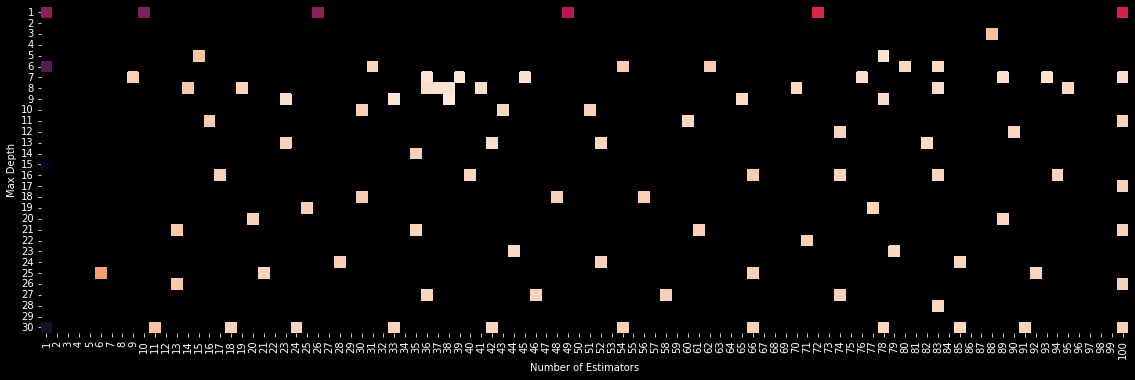

In [ ]:
# Plots heatmap of Random Forest train scores
#  on its hyperparameters search space
print(forest.best_estimator_)
res = pd.DataFrame(forest.cv_results_)[[
    'param_max_depth', 
    'param_n_estimators', 
    'mean_test_score', 
    'rank_test_score'
]]

x_min = N_ESTIMATORS_SPACE.bounds[0]
x_max = N_ESTIMATORS_SPACE.bounds[1]
y_min = MAX_DEPTH_SPACE.bounds[0]
y_max = MAX_DEPTH_SPACE.bounds[1]
n_x = x_max-x_min + 1
n_y = y_max-y_min + 1

grid = np.empty([n_y, n_x])
grid[:] = np.nan

for i in range(len(res)):
    grid[res.iloc[i, 0]-y_min, res.iloc[i, 1]-x_min] = res.iloc[i, 2]
         
plt.figure(figsize=(.2*n_x, .2*n_y));
ax = sns.heatmap(data=grid, cbar=False, square=True,
                 xticklabels=range(x_min, x_max+1), 
                 yticklabels=range(y_min, y_max+1)
);
ax.set(xlabel='Number of Estimators', ylabel='Max Depth');

Выводит таблицу поиска гиперпараметров модели случайного леса со средней метрикой на валидационной выборке.

In [ ]:
# Displays Random Forest hyperparameters search log  
pd.DataFrame(forest.cv_results_)[[
    'param_max_depth', 
    'param_n_estimators', 
    'mean_test_score', 
    'rank_test_score'
]].sort_values('rank_test_score')

,param_max_depth,param_n_estimators,mean_test_score,rank_test_score
72,9,38,0.964868,1
73,9,38,0.964868,1
71,7,39,0.963607,3
99,7,36,0.963393,4
62,9,33,0.963144,5
...,...,...,...,...
12,1,1,0.905699,96
84,1,10,0.902250,97
83,6,1,0.893164,98
43,30,1,0.880028,99


Выводит таблицу поиска гиперпараметров модели логистической регрессии со средней метрикой на валидационной выборке.

In [ ]:
# Displays Logit hyperparameters search log  
pd.DataFrame(logit.cv_results_)[[
    'param_penalty', 
    'param_solver', 
    'param_C',
    # 'param_l1_ratio',
    'mean_test_score', 
    'rank_test_score'
]].sort_values('rank_test_score')

,param_penalty,param_solver,param_C,mean_test_score,rank_test_score
48,l1,liblinear,3.162278,0.965722,1
26,l2,liblinear,10.0,0.965722,2
52,l1,liblinear,316.227766,0.965722,2
27,l2,newton-cg,31.622777,0.965722,2
28,l2,lbfgs,31.622777,0.965722,2
29,l2,liblinear,31.622777,0.965722,2
30,l2,newton-cg,100.0,0.965722,2
31,l2,lbfgs,100.0,0.965722,2
32,l2,liblinear,100.0,0.965722,2
33,l2,newton-cg,316.227766,0.965722,2


Выводит параметры обученной модели CatBoost.

In [ ]:
# CatBoost parameters
cat.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'class_names': [0, 1],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'AUC',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 10,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.00911100022494793,
 'loss_function': 'Logloss',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 22221117,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine'